### FashionMNIST cluster based on Autoencoder

-FashionMNIST is a dataset of grayscale images of 28x28 pixels representing 10 categories of clothing items.

-Though the dataset provides a label for each image, we can ignore all labels and use only images to do clustering tasks.

-This notebook uses Autoencoder to cluster the ten categories of FashionMNIST and compares the results.

### 运行说明：
### 该笔记需要python环境，环境中需确保有torch  matplotlib  torchvision  numpy库

==============================================================================================================================================================

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='fmnist_data/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [5]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_dataset.classes))
print('Unique labels:', train_dataset.classes)

Number of classes in dataset: 10
Unique labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [6]:
# 定义自编码器模型
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Autoencoder, self).__init__()
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 7 * 7, latent_dim),
            nn.Softmax(dim=1)  # 用于聚类的softmax层
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (16, 7, 7)),
            nn.ConvTranspose2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Upsample(scale_factor=2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [13]:
# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练循环
n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        img, _ = batch
        img = img.to(device)
        
        # 前向传播
        decoded, _ = model(img)
        loss = criterion(decoded, img)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}')

Epoch [5/30], Loss: 0.0257
Epoch [10/30], Loss: 0.0246
Epoch [15/30], Loss: 0.0240
Epoch [20/30], Loss: 0.0238
Epoch [25/30], Loss: 0.0236
Epoch [30/30], Loss: 0.0234


In [14]:
# 获取聚类结果
model.eval()
cluster_assignments = []
original_images = []
true_labels = []

with torch.no_grad():
    for batch in train_loader:
        img, labels = batch
        img = img.to(device)
        _, encoded = model(img)
        cluster_assignments.extend(torch.argmax(encoded, dim=1).cpu().numpy())
        original_images.extend(img.cpu().numpy())
        true_labels.extend(labels.numpy())

cluster_assignments = np.array(cluster_assignments)
original_images = np.array(original_images)
true_labels = np.array(true_labels)

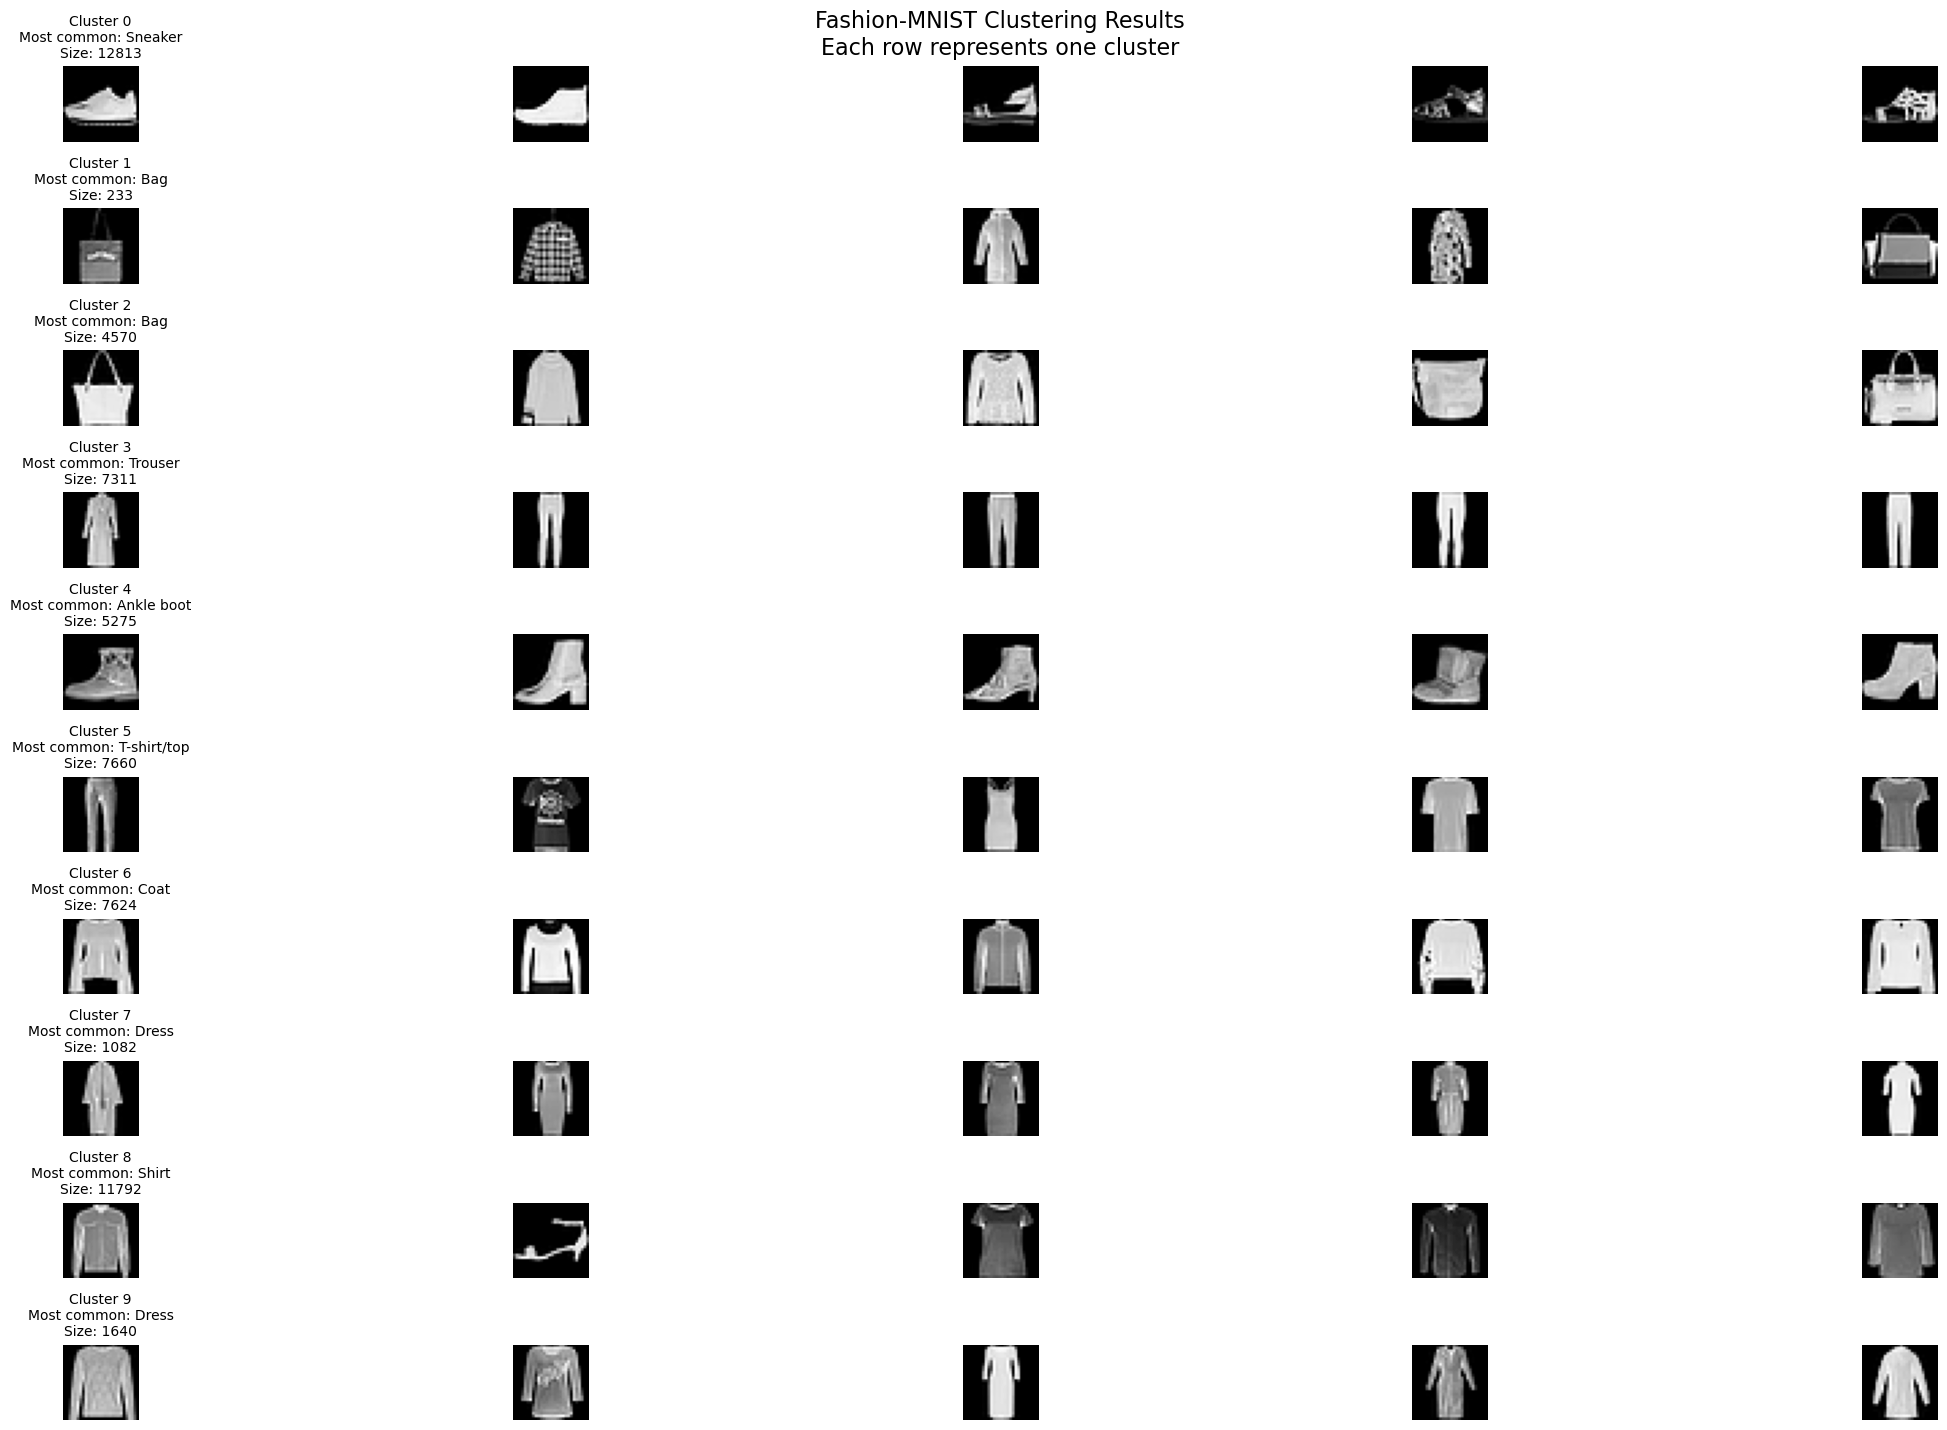

In [15]:
# 可视化结果
# 类别标签映射
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def visualize_clusters(images, assignments, true_labels, n_clusters=10):
    plt.figure(figsize=(25, 15))
    
    for i in range(n_clusters):
        cluster_images = images[assignments == i]
        cluster_true_labels = true_labels[assignments == i]
        
        # 获取该簇中最常见的真实标签
        if len(cluster_true_labels) > 0:
            most_common_label = np.bincount(cluster_true_labels).argmax()
            most_common_name = class_names[most_common_label]
        else:
            most_common_name = "Empty Cluster"
        
        # 计算该簇的大小
        cluster_size = len(cluster_images)
        
        for j in range(5):
            if j < len(cluster_images):
                plt.subplot(n_clusters, 5, i*5 + j + 1)
                plt.imshow(cluster_images[j][0], cmap='gray')
                
                if j == 0:  # 只在每行的第一个图像添加标注
                    plt.title(f'Cluster {i}\n'
                            f'Most common: {most_common_name}\n'
                            f'Size: {cluster_size}',
                            fontsize=10)
                plt.axis('off')
    
    plt.suptitle('Fashion-MNIST Clustering Results\nEach row represents one cluster',
                 fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

# 显示聚类结果
visualize_clusters(original_images, cluster_assignments, true_labels)

In [16]:
# 计算和显示聚类统计信息
def print_cluster_statistics(assignments, true_labels, n_clusters=10):
    print("\nCluster Statistics:")
    print("-" * 50)
    
    for i in range(n_clusters):
        cluster_true_labels = true_labels[assignments == i]
        cluster_size = len(cluster_true_labels)
        
        if cluster_size > 0:
            # 获取最常见的三个类别
            unique_labels, counts = np.unique(cluster_true_labels, return_counts=True)
            top_3_idx = np.argsort(-counts)[:3]
            
            print(f"\nCluster {i}:")
            print(f"Total items: {cluster_size}")
            print("Top 3 classes:")
            for idx in top_3_idx:
                label = unique_labels[idx]
                percentage = (counts[idx] / cluster_size) * 100
                print(f"- {class_names[label]}: {percentage:.1f}%")

# 显示统计信息
print_cluster_statistics(cluster_assignments, true_labels)


Cluster Statistics:
--------------------------------------------------

Cluster 0:
Total items: 12813
Top 3 classes:
- Sneaker: 45.9%
- Sandal: 28.3%
- Ankle boot: 14.0%

Cluster 1:
Total items: 233
Top 3 classes:
- Bag: 57.5%
- Coat: 17.2%
- Sneaker: 7.3%

Cluster 2:
Total items: 4570
Top 3 classes:
- Bag: 62.7%
- Coat: 16.5%
- Shirt: 9.1%

Cluster 3:
Total items: 7311
Top 3 classes:
- Trouser: 69.6%
- Dress: 25.3%
- Coat: 3.8%

Cluster 4:
Total items: 5275
Top 3 classes:
- Ankle boot: 78.4%
- Sandal: 19.5%
- Sneaker: 1.7%

Cluster 5:
Total items: 7660
Top 3 classes:
- T-shirt/top: 53.1%
- Dress: 24.0%
- Shirt: 14.3%

Cluster 6:
Total items: 7624
Top 3 classes:
- Coat: 42.9%
- Pullover: 38.5%
- Shirt: 16.4%

Cluster 7:
Total items: 1082
Top 3 classes:
- Dress: 57.9%
- Coat: 19.9%
- Shirt: 11.7%

Cluster 8:
Total items: 11792
Top 3 classes:
- Shirt: 23.0%
- Pullover: 20.3%
- T-shirt/top: 12.9%

Cluster 9:
Total items: 1640
Top 3 classes:
- Dress: 36.1%
- Shirt: 20.2%
- Pullover: 20.2%